# Variational Autoencoder

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import time

## Encoder Module

**Goal: Take as input images and output distribution parameters of approximate posterior**

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, latent_size):
        super().__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.layers = []
        
        # First layer
        self.layers.append(nn.Linear(self.input_size, self.hidden_size))
        self.layers.append(nn.ReLU())

        # 500 hidden layers (as per VAE paper for MNIST)
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(nn.ReLU())

        #Final Layer
        self.layers.append(nn.Linear(self.hidden_size, 2*self.latent_size)) #2*latent_size: Because distribution will be per pixel in latent dimension (first `latent_size`: mean, next `latent_size`: log(variance))

        #Sequential combination of above
        self.network = nn.Sequential(*self.layers)

    def forward(self, X):
        mu, log_sigma_2 = torch.split(self.network(X), self.latent_size, dim=-1)
        return mu, log_sigma_2

## Decoder Block

**Goal: Take Input the latent code, and output the distribution parameters of original image given latent code**

In [4]:
class Decoder(nn.Module):
    def __init__(self, num_layers, latent_size, hidden_size, output_size):
        super().__init__()
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.layers = []

        #First layer
        self.layers.append(nn.Linear(self.latent_size, self.hidden_size))
        self.layers.append(nn.ReLU())

        # 500 hidden layers
        self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.layers.append(nn.ReLU())

        #Final layer
        self.layers.append(nn.Linear(self.hidden_size, self.output_size)) #Only `output_size` no. of outputs because it is binary data, so bernoulli distribution (only one output needed per pixel)

        #Combined Network
        self.network = nn.Sequential (*self.layers)

    def forward(self, X):
        y = self.network(X)
        return y

## Variational Autoencoder

**Goal: Giving meaning to encoder and decoder**

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers

        self.encoder = Encoder(self.num_layers, self.input_size, self.hidden_size, self.latent_size)
        self.decoder = Decoder(self.num_layers, self.latent_size, self.hidden_size, self.input_size)

        self._init_params()

    def forward(self, X):
        # Encode
        mu, log_sigma_2 = self.encoder(X)
        # Sample Noise from fixed distribution
        epsilon = torch.randn(self.latent_size, device=X.device)
        sigma = torch.exp(0.5 * log_sigma_2)
        # Create latent code via latent transform
        z = mu + sigma*epsilon
        # Decode
        logits = self.decoder(z)

        return logits, mu, log_sigma_2

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

## Objective

In [6]:
class NegativeELBO(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # Use 'none' for manual reduction

    def forward(self, logits, labels, mu, log_sigma_2):
        # Reconstruction: sum over pixels (dim=1), then mean over batch
        reconstruction = self.bce(logits, labels).sum(dim=1).mean()
    
        # KL: sum over latent dims (dim=1), then mean over batch
        kl_divergence = (0.5 * (mu**2 + torch.exp(log_sigma_2) - log_sigma_2 - 1)).sum(dim=1).mean()
    
        neg_elbo = reconstruction + kl_divergence
        return neg_elbo, kl_divergence, reconstruction

## Training

### Train One Epoch

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device, update_freq):
    model.train()

    total_loss = 0.0
    total_kl_divergence = 0.0
    total_reconstruction = 0.0
    num_batches = 0

    for batch_idx, (features, _) in enumerate(dataloader):
        features = features.to(device)
        labels = features

        optimizer.zero_grad()

        features = features.view(features.size(0), -1)  # Flatten
        labels = labels.view(labels.size(0), -1)
        
        logits, mu, log_sigma_2 = model(features)

        loss, kl_divergence, reconstruction = criterion(logits, labels, mu, log_sigma_2)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_kl_divergence += kl_divergence.item()
        total_reconstruction += reconstruction.item()
        num_batches +=1

        if(batch_idx+1)%update_freq == 0:
            print(f'   Batch [{batch_idx+1}/{len(dataloader)}] - 'f'Loss: {loss.item():.4f} ; KL-Divergence: {kl_divergence.item() : .4f} ; Reconstruction: {reconstruction.item() : .4f}')

    avg_loss = total_loss/num_batches
    avg_kl_divergence = total_loss/num_batches
    avg_reconstruction = total_reconstruction/num_batches

    return avg_loss, avg_kl_divergence, avg_reconstruction

### Evaluate

In [8]:
def evaluate(model, dataloader, criterion, device, use_mean=False):
    model.eval()
    total_loss = 0.0
    total_kl_divergence = 0.0
    total_reconstruction = 0.0
    num_batches = 0

    all_reconstructions = []
    all_originals = []

    with torch.no_grad():
        for features, _ in dataloader:
            features = features.to(device)
            features = features.view(features.size(0), -1)
            logits, mu, log_sigma_2 = model(features)

            loss, kl_divergence, reconstruction = criterion(logits, features, mu, log_sigma_2)

            total_loss += loss.item()
            total_kl_divergence += kl_divergence.item()
            total_reconstruction += reconstruction.item()
            num_batches += 1

            #probabilites
            probs = torch.sigmoid(logits)

            all_reconstructions.append(probs.cpu())
            all_originals.append(features.cpu())

    avg_loss = total_loss / num_batches
    avg_kl_divergence = total_kl_divergence/num_batches
    avg_reconstruction = total_reconstruction/num_batches

    all_reconstructions = torch.cat(all_reconstructions, dim=0)
    all_originals = torch.cat(all_originals, dim=0)

    return avg_loss, avg_kl_divergence, avg_reconstruction, all_reconstructions, all_originals

### Combined Training function

In [9]:
def train_vae(num_epochs, model, train_dataloader, test_dataloader, criterion, optimizer, device, update_freq):
    train_losses = []
    test_losses = []
    train_kl_divergences = []
    test_kl_divergences = []
    train_reconstructions = []
    test_reconstructions = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        
        #Train
        print("INFO - Training...")
        train_loss, train_kl_divergence, train_reconstruction = train_epoch(model, train_dataloader, criterion, optimizer, device, update_freq=update_freq)
        
        #Eval
        print("INFO - Evaluating...")
        test_loss, test_kl_divergence, test_reconstruction, all_reconstructions, all_originals = evaluate(model, test_dataloader, criterion, device)
        
        # Store metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_kl_divergences.append(train_kl_divergence)
        test_kl_divergences.append(test_kl_divergence)
        train_reconstructions.append(train_reconstruction)
        test_reconstructions.append(test_reconstruction)
        
        epoch_time = time.time() - epoch_start_time
    
    total_time = time.time() - start_time
    print("\n" + "=" * 80)
    print("✅ Training completed!")
    print(f"🕒 Total training time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
    
    return train_losses, test_losses, train_kl_divergences, test_kl_divergences, train_reconstructions, test_reconstructions, all_reconstructions, all_originals

## MNIST dataset setup

In [10]:
def download_MNIST():
    transform = transforms.Compose([
        transforms.ToTensor(),  # scales to [0, 1]
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='../data/train',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='../data/test',
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, test_dataset


## Dataloaders

In [11]:
def create_DataLoaders(train_dataset, test_dataset, batch_size, shuffle_train, num_workers):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, test_loader

## Visualization Utilities

In [12]:
def plot_loss(train_losses, test_losses, save_path):
    epochs_range = range(1, len(train_losses) + 1)
    plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
    plt.plot(epochs_range, test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)  # dpi=300 gives high-quality image

    plt.show()

In [20]:
def plot_reconstructions(model, dataloader, device, num_images=8):
    import matplotlib.pyplot as plt
    model.eval()

    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.to(device)[:num_images]
        x_flat = x.view(x.size(0), -1)

        mu, _ = model.encoder(x_flat)
        z = mu  # deterministic
        logits = model.decoder(z)
        recon = torch.sigmoid(logits)

    side = int(x_flat.size(1) ** 0.5)
    x = x_flat.view(num_images, side, side).cpu()
    recon = recon.view(num_images, side, side).cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images*2, 4))
    for i in range(num_images):
        axes[0, i].imshow(x[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i], cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruction", fontsize=12)
    plt.show()

In [21]:
def plot_prior_samples(model, device, num_samples=16):
    import matplotlib.pyplot as plt
    model.eval()

    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_size).to(device)
        logits = model.decoder(z)
        samples = torch.sigmoid(logits)

    side = int(samples.size(1) ** 0.5)
    samples = samples.view(num_samples, side, side).cpu()

    grid_size = int(num_samples ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    for i in range(num_samples):
        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')

    plt.suptitle("Samples from p(z) ~ N(0, I)", fontsize=14)
    plt.show()


In [22]:
def plot_latent_interpolation(model, dataloader, device, steps=10):
    import matplotlib.pyplot as plt
    model.eval()

    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x1 = x[0:1].to(device)
        x2 = x[1:2].to(device)

        x1 = x1.view(1, -1)
        x2 = x2.view(1, -1)

        mu1, _ = model.encoder(x1)
        mu2, _ = model.encoder(x2)

        alphas = torch.linspace(0, 1, steps).to(device)
        zs = torch.stack([(1-a)*mu1 + a*mu2 for a in alphas]).squeeze(1)

        logits = model.decoder(zs)
        recon = torch.sigmoid(logits)

    side = int(recon.size(1) ** 0.5)
    recon = recon.view(steps, side, side).cpu()

    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i in range(steps):
        axes[i].imshow(recon[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Latent Interpolation", fontsize=14)
    plt.show()


## Coming Together

### Train Config

In [13]:
BATCH_SIZE = 100
NUM_EPOCHS = 50
NUM_WORKERS = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
train_dataset, test_dataset = download_MNIST()

train_dataloader, test_dataloader = create_DataLoaders(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle_train=True, num_workers=NUM_WORKERS)

model = VariationalAutoencoder(num_layers=2, input_size=784, hidden_size=256, latent_size=32)
model.to(DEVICE)

criterion = NegativeELBO()

optimizer = optim.Adagrad(model.parameters(), lr=0.01)

train_losses, test_losses, train_kl_divergences, test_kl_divergences, train_reconstructions, test_reconstructions, all_reconstructions, all_originals = train_vae(num_epochs=NUM_EPOCHS, train_dataloader=train_dataloader, test_dataloader=test_dataloader, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE, update_freq=100)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 39.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.65MB/s]



Epoch [1/50]
--------------------------------------------------
INFO - Training...
   Batch [100/600] - Loss: 203.9338 ; KL-Divergence:  1.1181 ; Reconstruction:  202.8157
   Batch [200/600] - Loss: 206.2895 ; KL-Divergence:  2.0160 ; Reconstruction:  204.2734
   Batch [300/600] - Loss: 194.5704 ; KL-Divergence:  2.6495 ; Reconstruction:  191.9209
   Batch [400/600] - Loss: 200.6749 ; KL-Divergence:  1.6594 ; Reconstruction:  199.0155
   Batch [500/600] - Loss: 194.6423 ; KL-Divergence:  2.8530 ; Reconstruction:  191.7893
   Batch [600/600] - Loss: 178.5490 ; KL-Divergence:  2.7471 ; Reconstruction:  175.8019
INFO - Evaluating...

Epoch [2/50]
--------------------------------------------------
INFO - Training...
   Batch [100/600] - Loss: 190.0647 ; KL-Divergence:  2.9383 ; Reconstruction:  187.1264
   Batch [200/600] - Loss: 197.9649 ; KL-Divergence:  3.7674 ; Reconstruction:  194.1975
   Batch [300/600] - Loss: 189.4806 ; KL-Divergence:  2.6414 ; Reconstruction:  186.8391
   Batch [

### Save Results

In [15]:
torch.save(model.state_dict(), "vae_weights.pth")

In [16]:
torch.save({
        'epoch': NUM_EPOCHS,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_kl_divergences': train_kl_divergences,
        'train_reconstructions': train_reconstructions,
        'test_losses': test_losses,
        'test_kl_divergences': test_kl_divergences,
        'test_reconstructions': test_reconstructions,
    }, "vae_detailed.pth")

## Visualize Results

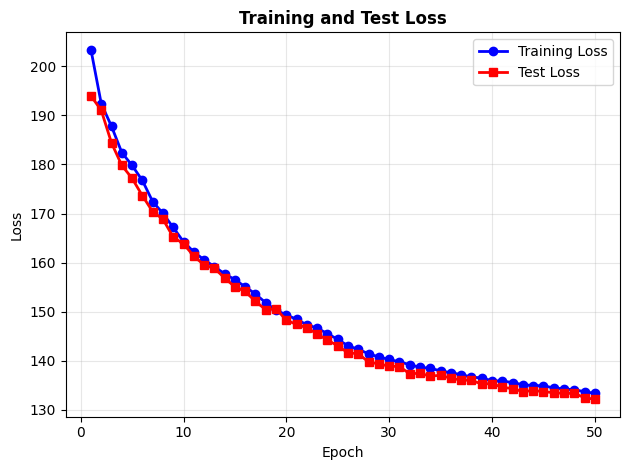

In [17]:
plot_loss(train_losses, test_losses, "neg-elbo")

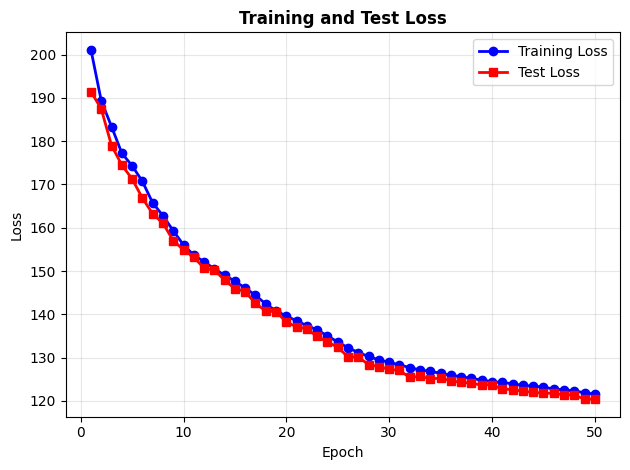

In [18]:
plot_loss(train_reconstructions, test_reconstructions, "reconstructions")

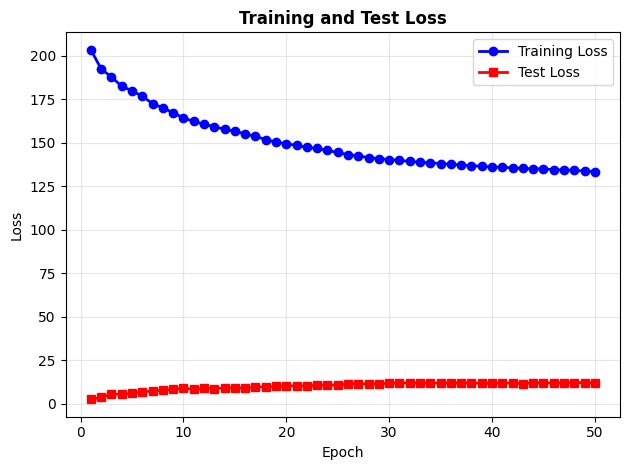

In [19]:
plot_loss(train_kl_divergences, test_kl_divergences, "kl_divergence")

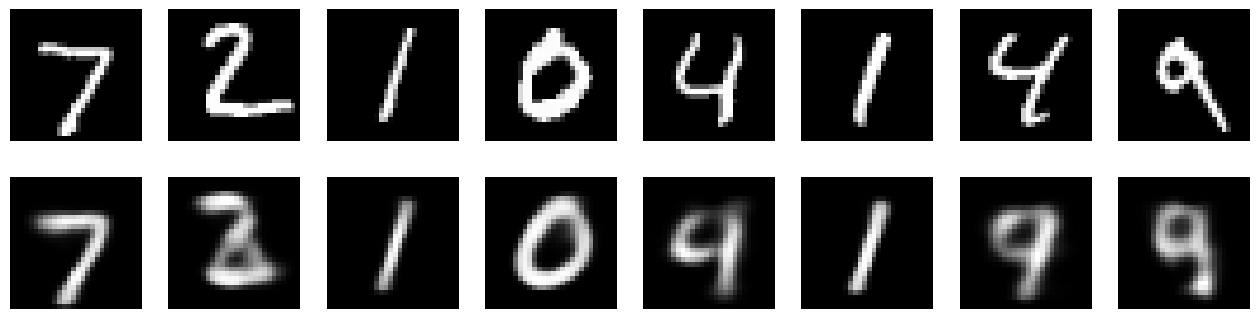

In [23]:
plot_reconstructions(model, test_dataloader, DEVICE)

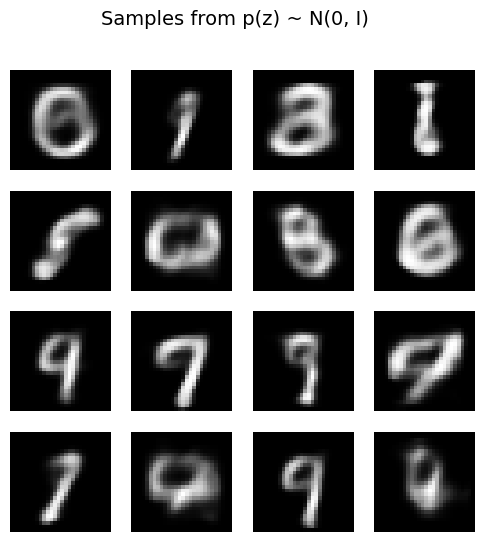

In [24]:
plot_prior_samples(model, DEVICE)

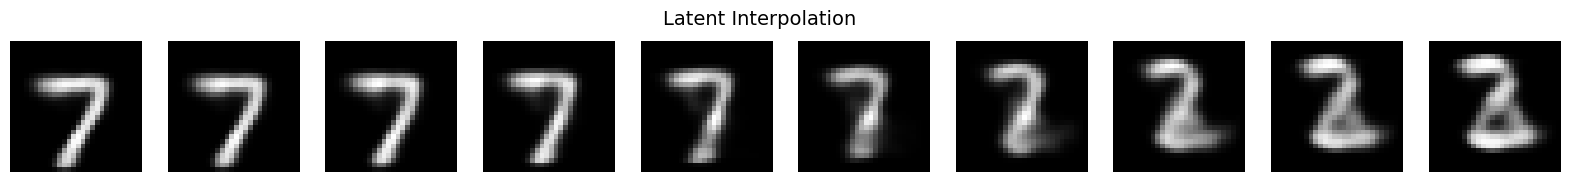

In [25]:
plot_latent_interpolation(model, test_dataloader, DEVICE)